In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
import json
from tqdm import tqdm
import cv2
import shutil
from collections import defaultdict
from PIL import Image
import os
import torch
from ultralytics import YOLO
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity

pd.options.display.max_colwidth = None

DATASET_PATH = "./../lisa-traffic-light-dataset/data"
DAY_ANNOTATIONS = os.path.join(DATASET_PATH, "Annotations/Annotations/dayTrain")
NIGHT_ANNOTATIONS = os.path.join(DATASET_PATH, "Annotations/Annotations/nightTrain")
AUGMENTED_IMAGES_FOLDER = "./../lisa-augmented"

# Data preprocessing

Initial preprocessing based on: https://www.kaggle.com/code/meemr5/traffic-light-detection-pytorch-starter

In [8]:
# read annotations files
df_annotations = []
for clip_folder in os.listdir(DAY_ANNOTATIONS):
    if 'dayClip' not in clip_folder:
        continue
    annotations_file = os.path.join(os.path.join(DAY_ANNOTATIONS, clip_folder), "frameAnnotationsBOX.csv")
    df = pd.read_csv(annotations_file, sep = ";")
    df_annotations.append(df)

for clip_folder in os.listdir(NIGHT_ANNOTATIONS):
    if 'nightClip' not in clip_folder:
        continue
    annotations_file = os.path.join(os.path.join(NIGHT_ANNOTATIONS, clip_folder), "frameAnnotationsBOX.csv")
    df = pd.read_csv(annotations_file, sep = ";")
    df_annotations.append(df)

df = pd.concat(df_annotations).reset_index(drop=True)
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip9--00000.jpg,stop,896,304,911,331,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0
1,dayTraining/dayClip9--00000.jpg,stop,1117,386,1135,404,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0
2,dayTraining/dayClip9--00000.jpg,stopLeft,775,301,796,332,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0
3,dayTraining/dayClip9--00000.jpg,stopLeft,252,366,273,397,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,0
4,dayTraining/dayClip9--00001.jpg,stop,894,304,909,326,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,1,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,1
...,...,...,...,...,...,...,...,...,...,...
51821,nightTraining/nightClip1--00492.jpg,go,872,17,958,143,nightTraining/nightClip1/clip1.mp4,492,nightTraining/nightClip1/clip1.mp4,492
51822,nightTraining/nightClip1--00493.jpg,go,938,5,1028,131,nightTraining/nightClip1/clip1.mp4,493,nightTraining/nightClip1/clip1.mp4,493
51823,nightTraining/nightClip1--00494.jpg,go,1006,6,1094,117,nightTraining/nightClip1/clip1.mp4,494,nightTraining/nightClip1/clip1.mp4,494
51824,nightTraining/nightClip1--00495.jpg,go,1081,0,1171,110,nightTraining/nightClip1/clip1.mp4,495,nightTraining/nightClip1/clip1.mp4,495


In [9]:
# remove irrelevant columns and change names
df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)

label_to_idx = {'go': 0, 'warning': 1, 'stop': 2}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def change_annotations(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(change_annotations, axis=1)

df.columns = ['image_file', 'label', 'x_min', 'y_min', 'x_max', 'y_max']

df['clip_name'] = df[['image_file']].applymap(lambda x: x.split('/')[1].split('--')[0])
df

,image_file,label,x_min,y_min,x_max,y_max,clip_name
0,dayTraining/dayClip9--00000.jpg,2,896,304,911,331,dayClip9
1,dayTraining/dayClip9--00000.jpg,2,1117,386,1135,404,dayClip9
2,dayTraining/dayClip9--00000.jpg,2,775,301,796,332,dayClip9
3,dayTraining/dayClip9--00000.jpg,2,252,366,273,397,dayClip9
4,dayTraining/dayClip9--00001.jpg,2,894,304,909,326,dayClip9
...,...,...,...,...,...,...,...
51821,nightTraining/nightClip1--00492.jpg,0,872,17,958,143,nightClip1
51822,nightTraining/nightClip1--00493.jpg,0,938,5,1028,131,nightClip1
51823,nightTraining/nightClip1--00494.jpg,0,1006,6,1094,117,nightClip1
51824,nightTraining/nightClip1--00495.jpg,0,1081,0,1171,110,nightClip1


# Classes stats

In [10]:
color_map = {0:'green', 1:'yellow', 2:'red'}

def print_class_stats(df):
    index, counts = np.unique(df['label'], return_counts=True)
    colors = [color_map[target] for target in index]
    index = [idx_to_label[i] for i in index]
    plt.bar(index, counts, color=colors)
    for i in range(len(index)):
        print(f"{index[i]}: {counts[i]}")
    print(f"images: {len(np.unique(df['image_file']))}")

go: 24182
stop: 26089
images: 18013


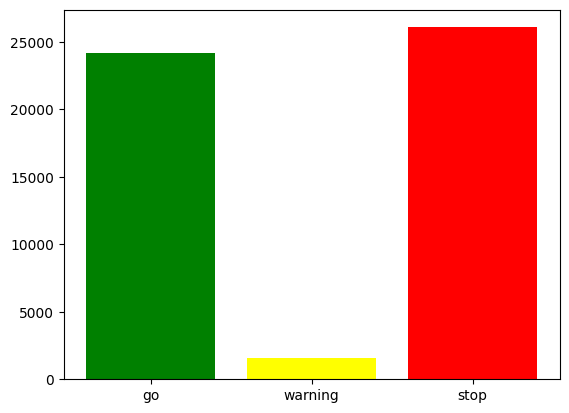

In [35]:
print_class_stats(df)

# Remove almost identical images

Based on CLIP extractions

In [ ]:
def get_file_path(img_path):
    image = img_path.split('/')[-1]
    train_path = 'dayTrain' if 'day' in img_path else 'nightTrain'
    return os.path.join(DATASET_PATH, f"{train_path}/{train_path}/{image.split('--')[0]}/frames/{image}")
    

DEVICE = 'mps'
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_images_from_df(image_files, batch_size=32):
    images_embeddings = []
    for i in tqdm(range(0, len(image_files), batch_size)):
        batch_paths = image_files[i:i + batch_size]             # get batch
        batch_images = [Image.open(get_file_path(img_path)) for img_path in batch_paths]
        # process images
        image_inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        # get batch embeddings
        with torch.no_grad():
            batch_embeddings = model.get_image_features(**image_inputs.to(DEVICE))
        images_embeddings.append(batch_embeddings)
    return torch.cat(images_embeddings, dim=0)

def remove_duplicates_from_df(df, threshold=0.98):
    unique_image_files = df.image_file.unique()
    # get image embeddings
    image_embeddings = preprocess_images_from_df(unique_image_files)
    # compute cosine similarity
    image_embeddings_np = image_embeddings.cpu().numpy()
    cosine_sim_matrix = cosine_similarity(image_embeddings_np)
    print(cosine_sim_matrix.shape)

    duplicate_indices = np.argwhere(cosine_sim_matrix > threshold)

    file_label_counts = defaultdict(lambda: defaultdict(int))
    for _, row in df.iterrows():
        image_file = row['image_file']
        label = row['label']
        file_label_counts[image_file][label] += 1

    file_to_clip_name = dict(zip(df.image_file, df.clip_name))
    
    to_remove = set()
    for i, j in duplicate_indices:
        if i == j:
            continue
        i_file = unique_image_files[i]
        j_file = unique_image_files[j]
        if file_to_clip_name[i_file] != file_to_clip_name[j_file]:  # from different clips
            continue
        if i_file in to_remove or j_file in to_remove:  # one is already to remove
            continue
        if file_label_counts[j_file][1] > 0:          # keep images with yellow lights (low number of cases)
            continue
        if file_label_counts[i_file] == file_label_counts[j_file]:  # same labels
            to_remove.add(j_file)

    rows_to_remove = df[df['image_file'].isin(to_remove)].index
    df_updated = df.drop(rows_to_remove).reset_index(drop=True)
    return df_updated

df_updated = remove_duplicates_from_df(df)
#df_updated.to_csv('./updated_lisa_data.csv')

In [11]:
df_updated = pd.read_csv("./updated_lisa_data.csv", sep = ",", index_col=0)
df_updated

,image_file,label,x_min,y_min,x_max,y_max,clip_name
0,dayTraining/dayClip9--00000.jpg,2,896,304,911,331,dayClip9
1,dayTraining/dayClip9--00000.jpg,2,1117,386,1135,404,dayClip9
2,dayTraining/dayClip9--00000.jpg,2,775,301,796,332,dayClip9
3,dayTraining/dayClip9--00000.jpg,2,252,366,273,397,dayClip9
4,dayTraining/dayClip9--00003.jpg,2,890,302,905,320,dayClip9
...,...,...,...,...,...,...,...
10783,nightTraining/nightClip1--00492.jpg,0,872,17,958,143,nightClip1
10784,nightTraining/nightClip1--00493.jpg,0,938,5,1028,131,nightClip1
10785,nightTraining/nightClip1--00494.jpg,0,1006,6,1094,117,nightClip1
10786,nightTraining/nightClip1--00495.jpg,0,1081,0,1171,110,nightClip1


go: 5460
stop: 3773
images: 3989


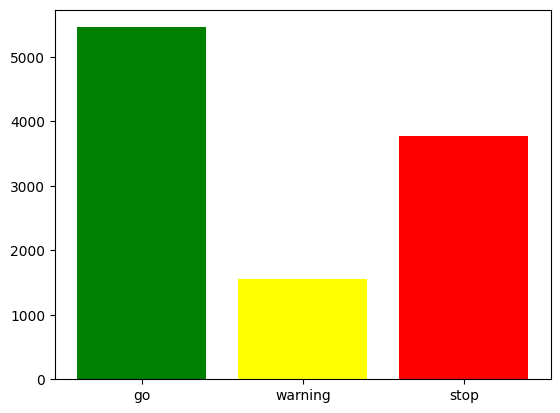

In [12]:
print_class_stats(df_updated)

# Split for training, validation and test sets

In [13]:
def split(df, p=0.10):
    clip_names = sorted(df['clip_name'].unique())

    day_clips = [name for name in clip_names if 'day' in name]
    night_clips = [name for name in clip_names if 'night' in name]

    train_day_clips, test_day_clips = train_test_split(day_clips, test_size=p, random_state=42)
    train_night_clips, test_night_clips = train_test_split(night_clips, test_size=p, random_state=42)

    train_clips = train_day_clips + train_night_clips
    test_clips = test_day_clips + test_night_clips

    train_df = df[df.clip_name.isin(train_clips)]
    test_df = df[df.clip_name.isin(test_clips)]

    return train_df, test_df


df_train, df_test = split(df_updated)
df_train, df_val = split(df_train)

print(df_train)
print(df_test)
print(df_val)

                                image_file  label  x_min  y_min  x_max  y_max  \
0          dayTraining/dayClip9--00000.jpg      2    896    304    911    331   
1          dayTraining/dayClip9--00000.jpg      2   1117    386   1135    404   
2          dayTraining/dayClip9--00000.jpg      2    775    301    796    332   
3          dayTraining/dayClip9--00000.jpg      2    252    366    273    397   
4          dayTraining/dayClip9--00003.jpg      2    890    302    905    320   
...                                    ...    ...    ...    ...    ...    ...   
10783  nightTraining/nightClip1--00492.jpg      0    872     17    958    143   
10784  nightTraining/nightClip1--00493.jpg      0    938      5   1028    131   
10785  nightTraining/nightClip1--00494.jpg      0   1006      6   1094    117   
10786  nightTraining/nightClip1--00495.jpg      0   1081      0   1171    110   
10787  nightTraining/nightClip1--00496.jpg      0   1158      0   1246    101   

        clip_name  
0      

go: 1303
stop: 739
images: 891


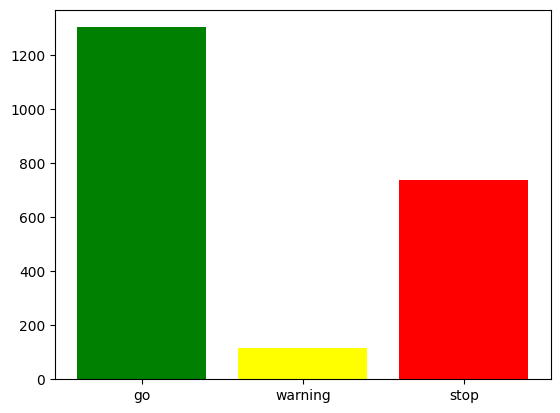

In [40]:
print_class_stats(df_test)

go: 1056
stop: 477
images: 660


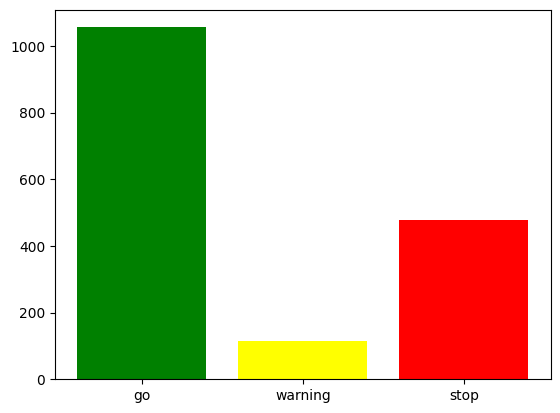

In [41]:
print_class_stats(df_val)

go: 3101
stop: 2557
images: 2438


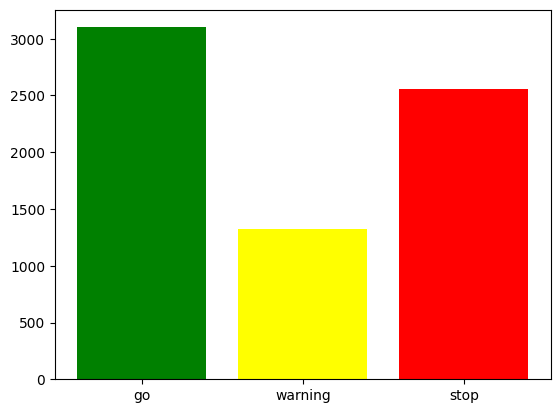

In [14]:
print_class_stats(df_train)

# Attempt for an even distribution

Randomly select images with green and red annotations to try to match the target (yellow cases)

go: 1876
stop: 1451
images: 1538


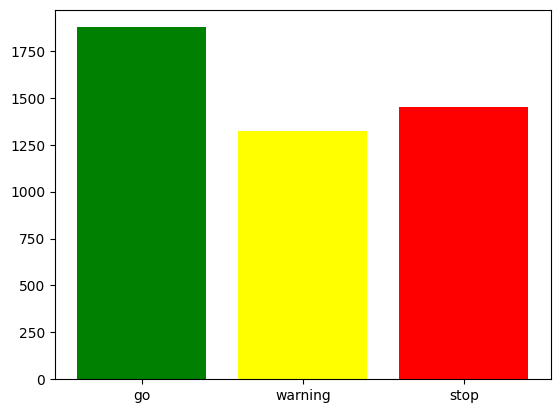

In [48]:
grouped = df_train.groupby('image_file').agg({'label': list}).reset_index()

# separate columns for the count of each class in each image
grouped['go_count'] = grouped['label'].apply(lambda x: x.count(label_to_idx['go']))
grouped['stop_count'] = grouped['label'].apply(lambda x: x.count(label_to_idx['stop']))
grouped['warning_count'] = grouped['label'].apply(lambda x: x.count(label_to_idx['warning']))

yellow_images = grouped[grouped['warning_count'] > 0]
yellow_annotations_size = yellow_images['warning_count'].sum()

green_counter = 0
red_counter = 0
non_yellow_images = grouped[grouped['warning_count'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)       # shuffle non yellow ones

balanced_non_yellow_images = []
for _, row in non_yellow_images.iterrows():
    go_count = row['go_count']
    stop_count = row['stop_count']

    if red_counter <= green_counter and stop_count > 0:
        balanced_non_yellow_images.append(row['image_file'])
        red_counter += stop_count
        green_counter += go_count
    elif go_count > 0:
        balanced_non_yellow_images.append(row['image_file'])
        green_counter += go_count
        red_counter += stop_count
    if green_counter >= yellow_annotations_size and red_counter >= yellow_annotations_size:
        break

balanced_images = set()
balanced_images.update(yellow_images['image_file'])
balanced_images.update(balanced_non_yellow_images)

df_balanced = df_train[df_train['image_file'].isin(balanced_images)]      # filter the selected ones
print_class_stats(df_balanced)

# Augment training set images

In [52]:
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.Rotate(limit=10, p=0.5),  # 10 degrees rotation
        A.MotionBlur(p=0.2),
        A.OneOf([
            A.RandomRain(p=0.2),
            A.RandomFog(p=0.2),
        ], p=0.2),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def augment_image(image, bboxes, class_labels, augmentation_pipeline):
    augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
    return augmented['image'], augmented['bboxes'], augmented['class_labels']

def create_augmentation_images(df):
    augmentation_pipeline = get_augmentation_pipeline()

    annotations_dict = {}
    for image_file in tqdm(df['image_file'].unique()):
        group = df[df['image_file'] == image_file]
        bboxes = []
        class_labels = []
        clip_name = group.iloc[0]['clip_name']

        for _, row in group.iterrows():
            x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
            class_label = row['label']
            bboxes.append([x_min, y_min, x_max, y_max])
            class_labels.append(class_label)

        image = cv2.imread(get_file_path(image_file))
        aug_image, aug_bboxes, aug_class_labels = augment_image(image, bboxes, class_labels, augmentation_pipeline)
        aug_image_file = f"aug_{os.path.basename(image_file)}"
        aug_image_path = os.path.join(AUGMENTED_IMAGES_FOLDER, aug_image_file)
        cv2.imwrite(aug_image_path, aug_image)

        annotations_dict[aug_image_file] = {
            'clip_name': clip_name,
            'annotations': []
        }
        for bbox, label in zip(aug_bboxes, aug_class_labels):
            x_min, y_min, x_max, y_max = map(int, bbox)
            annotations_dict[aug_image_file]['annotations'].append({
                'label': label,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max
            })

    with open(os.path.join(AUGMENTED_IMAGES_FOLDER, "annotations.json"), 'w') as f:
        json.dump(annotations_dict, f, indent=4)

create_augmentation_images(df_balanced)

100%|██████████| 1538/1538 [00:42<00:00, 36.16it/s]


In [66]:
with open(os.path.join(AUGMENTED_IMAGES_FOLDER, "annotations.json"), 'r') as f:
    augmented_data = json.load(f)

new_rows = []
for aug_image_file, aug_data in augmented_data.items():
    clip_name = aug_data['clip_name']
    annotations = aug_data['annotations']
    for annotation in annotations:
        new_row = {
            'image_file': os.path.join(AUGMENTED_IMAGES_FOLDER, aug_image_file),
            'label': annotation['label'],
            'x_min': annotation['x_min'],
            'y_min': annotation['y_min'],
            'x_max': annotation['x_max'],
            'y_max': annotation['y_max'],
            'clip_name': clip_name
        }
        new_rows.append(new_row)

df_augmented = pd.DataFrame(new_rows)

df_balanced.loc[:, 'image_file'] = df_balanced['image_file'].apply(get_file_path)
df_train_updated = pd.concat([df_balanced, df_augmented], ignore_index=True)

df_val.loc[:, 'image_file'] = df_val['image_file'].apply(get_file_path)
df_test.loc[:, 'image_file'] = df_test['image_file'].apply(get_file_path)

go: 3752
stop: 2902
images: 3076


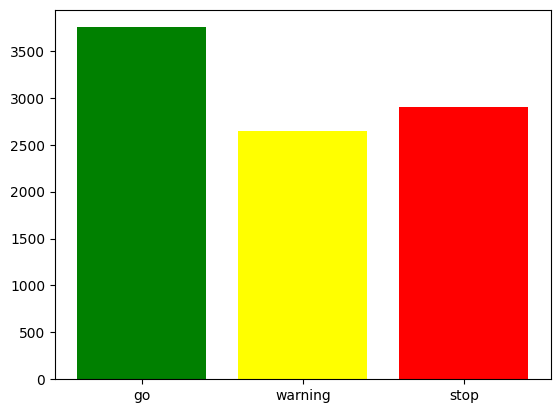

In [68]:
print_class_stats(df_train_updated)

# Create YOLO format folders

In [71]:
dataset_path = "lisa_tld_yolo_2"

train_dir_path = os.path.join(dataset_path, 'train')
val_dir_path = os.path.join(dataset_path, 'val')
test_dir_path = os.path.join(dataset_path, 'test')

for dir in [train_dir_path, val_dir_path, test_dir_path]:
    os.makedirs(os.path.join(dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'labels'), exist_ok=True)

In [72]:
def convert_to_yolo_format(bndbox, image_width, image_height):
    xmin, ymin, xmax, ymax = bndbox['x_min'], bndbox['y_min'], bndbox['x_max'], bndbox['y_max']
    x_center = (xmin + xmax) / 2 / image_width
    y_center = (ymin + ymax) / 2 / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    return x_center, y_center, width, height

def write_yolo_format_data(annot_pairs, dir):
    for image_path, label in annot_pairs:
        image_file_name = f"{os.path.basename(image_path)}"
        image_new_path = os.path.join(dir, "images", image_file_name)
        shutil.copy(image_path, image_new_path)
        label_file_name = os.path.splitext(image_file_name)[0] + ".txt"
        label_path = os.path.join(dir, "labels", label_file_name)
        with open(label_path, 'a') as label_file:
            label_file.write(label)

def create_yolo_format_dataset(df, set_path):
    traffic_light_annotations = defaultdict(list)

    for _, annotations in df.iterrows():
        image_path = annotations['image_file']
        image_width, image_height = Image.open(image_path).size
        x_center, y_center, width, height = convert_to_yolo_format(annotations, image_width, image_height)
        yolo_format_line = f"{annotations['label']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
        if yolo_format_line not in traffic_light_annotations[image_path]:
            traffic_light_annotations[image_path].append(yolo_format_line)

    formatted_annotations = []
    for image_path, yolo_annot in traffic_light_annotations.items():
        formatted_annotations.append((image_path, ''.join(yolo_annot)))
    write_yolo_format_data(formatted_annotations, set_path)

create_yolo_format_dataset(df_train_updated, train_dir_path)
create_yolo_format_dataset(df_val, val_dir_path)
create_yolo_format_dataset(df_test, test_dir_path)

# GIFs with final results

In [10]:
FPS = 24
DURATION = int(1000 / FPS)

def create_gif_with_results(model, frames_dir, output_path, max_frames=500, resize=(320, 240)):
    image_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])[:max_frames]
    resized_images = [Image.open(img).resize(resize).convert('RGB') for img in image_files]

    results = model(resized_images, conf=0.30)
    annotated_frames = [Image.fromarray(result.plot()[:, :, ::-1]) for result in results]       # bgr to rgb 
    
    annotated_frames[0].save(
        output_path,
        save_all=True,
        append_images=annotated_frames[1:], 
        duration=DURATION,
        loop=0
    )
    print(f"GIF saved as {output_path}")


In [11]:
model = YOLO('./../models/yolo8s_train_29ep_tf/weights/best.pt')

day_frames_dir = './../lisa-traffic-light-dataset/data/nightSequence1/nightSequence1/frames'
day_output_path = './../output/output_nightSequence1_1.gif'
create_gif_with_results(model, day_frames_dir, day_output_path, resize=(640, 480))


0: 480x640 1 green, 168.1ms
1: 480x640 1 green, 168.1ms
2: 480x640 1 green, 168.1ms
3: 480x640 1 green, 168.1ms
4: 480x640 1 green, 168.1ms
5: 480x640 1 green, 168.1ms
6: 480x640 1 green, 168.1ms
7: 480x640 1 green, 168.1ms
8: 480x640 1 green, 168.1ms
9: 480x640 1 green, 168.1ms
10: 480x640 1 green, 168.1ms
11: 480x640 1 green, 168.1ms
12: 480x640 1 green, 168.1ms
13: 480x640 1 green, 168.1ms
14: 480x640 1 green, 168.1ms
15: 480x640 1 green, 168.1ms
16: 480x640 1 green, 168.1ms
17: 480x640 1 green, 168.1ms
18: 480x640 1 green, 168.1ms
19: 480x640 1 green, 168.1ms
20: 480x640 1 green, 168.1ms
21: 480x640 1 green, 168.1ms
22: 480x640 1 green, 168.1ms
23: 480x640 1 green, 168.1ms
24: 480x640 1 green, 168.1ms
25: 480x640 1 green, 168.1ms
26: 480x640 1 green, 168.1ms
27: 480x640 1 green, 168.1ms
28: 480x640 1 green, 168.1ms
29: 480x640 1 green, 168.1ms
30: 480x640 1 green, 168.1ms
31: 480x640 1 green, 168.1ms
32: 480x640 1 green, 168.1ms
33: 480x640 1 green, 168.1ms
34: 480x640 1 green, 16